# Efficient Operations with Spatial Indexing

* __Spatial Index:__ way of structuring data in a way that makes accessing and performing operations on the spatial object more efficient
* can dramatically increase speed of spatial operations (e.g, joins, intersections)

This notebook will introduce you to
* __R-tree spatial index:__ one of the most common spatial indexes in use today
    * R-tree represents observations and their minimum bounding rectangles (MBRs) as the lowest level of the spatial index
    * R stands for _rectangle_
    * read this article for more info: https://geoffboeing.com/2016/10/r-tree-spatial-index-python/#:~:text=An%20R%2Dtree%20represents%20individual,higher%20level%20of%20the%20index.
 
* __H3__ spatial index
    * Hexagonical Hierarchichal (H3)
    * H3 grid comprises nesting hexagons that cover the Earth's surface
    * 16 resolutions

## 1.1 Package Imports

In [1]:
import geopandas as gpd
import pandas as pd
import time
from shapely.geometry import Point, Polygon, MultiPolygon
import osmnx as ox
import warnings
warnings.filterwarnings('ignore')
import matplotlib.pyplot as plt

## 1.2 Data Import

In [2]:
# Setting the file path
path = '../Data/Data_pt1/'

In [3]:
# Reading in the data as a Pandas DataFrame
#REMINDER - The listings data must be downloaded from Inside Airbnb
listings = pd.read_csv(path + 'NY_Airbnb_Oct_2023/listings.csv.gz', compression='gzip', low_memory=False)

# Converting it to a GeoPandas DataFrame
listings_gpdf = gpd.GeoDataFrame(
    listings,
    geometry=gpd.points_from_xy(listings['longitude'],
                                   listings['latitude'],
                                   crs="EPSG:4326")
)

# Printing the shape of the DataFrame
listings_gpdf.shape

(38792, 76)

We have 38,792 listings in New York.

Filter the AirBnB data down to that within Manhattan without spatial index:

In [4]:
# Focusing on attractions in Manhattan, so we need to create a mask to filter locations 
# in the Manhattan borough
boroughs = gpd.read_file(path + "NYC Boroughs/nybb_22a/nybb.shp")

boroughs = boroughs.to_crs('EPSG:4326')
manhattan = boroughs[boroughs['BoroName']=='Manhattan']

# extract manhattan geometry
geometry = manhattan.loc[3, 'geometry']

# get the start time
st = time.time()

listings_mask = listings_gpdf.within(geometry)

listings_manhattan = listings_gpdf.loc[listings_mask]

# get the end time
et = time.time()

# get the execution time
elapsed_time = et - st
print('Execution time:', elapsed_time, 'seconds')

Execution time: 24.19976496696472 seconds


In [5]:
listings_manhattan.shape

(16904, 76)

We have 16904 listings in Manhattan.

# 2.0 Spatial Indexing

## 2.1 R-Tree

* to implement R-tree in GeoPandas, simply execute the _.sindex_ method

In [6]:
## Perform filter using spatial index

# Building the R-tree spatial index on New York dataset
sindex = listings_gpdf.sindex

# get the start time
st = time.time()

# Getting the indexes of the possible matches from the R-tree
idex_possible_matches = list(sindex.intersection(geometry.bounds))

# subsetting the dataframe to be only possible matches
possible_matches_df = listings_gpdf.iloc[idex_possible_matches]

# Performing an intersection to get the precise matches
precise_matches_df = possible_matches_df[possible_matches_df.intersects(geometry)]

# get the end time
et = time.time()

# get the execution time
elapsed_time = et - st
print('Execution time:', elapsed_time, 'seconds')

Execution time: 24.24245572090149 seconds


In [7]:
# check we only have Manhattan listings:
precise_matches_df.shape

(16904, 76)

This was about the same time.

One limitation of R-tree indexes is that if the filtering polygon and spatial observations have the same MBR, the R-tree index will identify each of the points as a possible match and not yield huge efficiency gains.

One work-around is to subdivide your filtering polygon into smaller polygons and then iterate through those smaller polygons to identify matching locations.

### 2.1.1 R-Tree with Subdivided Polygons

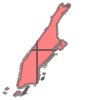

In [8]:
# Create the subdivided polygons
subdivided_polygon = ox.utils_geo._quadrat_cut_geometry(geometry, quadrat_width=1) # quadrant_width is in the CRS measurement units (4326:degrees)
subdivided_polygon

In [9]:
## Iterate through the subdivided polygons to identify Manhattan listings

# get the start time
st = time.time()

points_in_geometry = pd.DataFrame()
for geom in subdivided_polygon.geoms:
    # add in a slight buffer to account for points falling on the lines of the subdivided polygons
    geom = geom.buffer(1e-14).buffer(0)

    # Getting the indexes of the possible matches from the R-tree
    idex_possible_matches = list(sindex.intersection(geom.bounds))
    possible_matches_df = listings_gpdf.iloc[idex_possible_matches]
    
    # Performing an intersection to get the precise matches
    precise_matches_df = possible_matches_df[possible_matches_df.intersects(geom)]
    #points_in_geometry = points_in_geometry.append(precise_matches_df)
    points_in_geometry = pd.concat([points_in_geometry, precise_matches_df], ignore_index=True)

# get the end time
et = time.time()

# get the execution time
elapsed_time = et - st
print('Execution time:', elapsed_time, 'seconds')

Execution time: 5.765035152435303 seconds


In [10]:
points_in_geometry.shape

(16904, 76)

This was not much faster!

---

## 2.2 H3

* use H3 index to count number of AirBnBs across Manhattan

In [11]:
# Reference Materials
# https://www.uber.com/blog/h3/
# https://spatialthoughts.com/2020/07/01/point-in-polygon-h3-geopandas/

In [12]:
%matplotlib inline 
from h3 import h3
import contextily

In [13]:
# Set the H3 resolution
h3_resolution = 8
 
# Creating a function to add the H3 identifier to each of the Airbnb Points
def add_h3_id(row):
    return h3.geo_to_h3(
      row.geometry.y, row.geometry.x, h3_resolution)


# get the start time
st = time.time()

# Executing the function
listings_manhattan['h3'] = listings_gpdf.apply(add_h3_id, axis=1)

# Creating a dataframe with the count of airbnb's within each hexagon
airbnb_count = listings_manhattan.groupby(['h3']).h3.agg('count').to_frame('count').reset_index()
# sum up for all hexes
print(airbnb_count['count'].sum())

# get the end time
et = time.time()

# get the execution time
elapsed_time = et - st
print('Execution time:', elapsed_time, 'seconds')

16904
Execution time: 0.8976898193359375 seconds


In [14]:
## Append the hexagon geometry to the aggregated DataFrame for visualizatin purposes

# Defining a function to get the geometry for each of the H3 hexagons
def add_h3_geometry(row):
    points = h3.h3_to_geo_boundary(
      row['h3'], True)
    return Polygon(points)

# Adding the geometry to the airbnb_count dataframe
airbnb_count['geometry'] = airbnb_count.apply(add_h3_geometry, axis=1)

# Converting to a geodataframe
gdf = gpd.GeoDataFrame(airbnb_count, crs='EPSG:4326')
gdf.head()

,h3,count,geometry
0,882a100881fffff,104,"POLYGON ((-73.97278 40.80229, -73.97917 40.801..."
1,882a100883fffff,246,"POLYGON ((-73.97033 40.79441, -73.97672 40.793..."
2,882a100887fffff,11,"POLYGON ((-73.98114 40.79677, -73.98752 40.795..."
3,882a100889fffff,261,"POLYGON ((-73.96443 40.80780, -73.97081 40.806..."
4,882a10088bfffff,284,"POLYGON ((-73.96198 40.79993, -73.96837 40.798..."


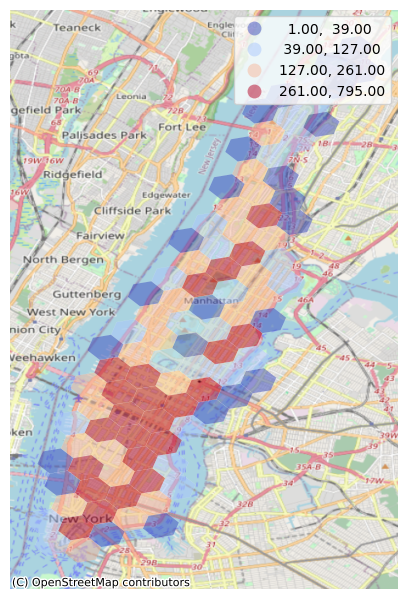

In [16]:
# Plotting a choropleth map of the Airbnb's within each cell
f, ax = plt.subplots(1, figsize=(5, 10))
   
# Plot choropleth of counts
gdf.plot(
    column='count', 
    cmap='coolwarm', 
    scheme='quantiles',
    k=4, 
    edgecolor='white', 
    linewidth=0.1, 
    alpha=0.5,
    legend=True,
    ax=ax
)

# Add basemap
contextily.add_basemap(
    ax,
    crs=gdf.crs,
    #source=contextily.providers.Stamen.TonerLite,
    source=contextily.providers.OpenStreetMap.Mapnik,
)
    
# Remove axis
ax.set_axis_off()

# Display
plt.show()
#f.savefig(path + r"Neighborhood Residuals.png")